In [1]:
import pandas as pd
from zipline.api import symbol, set_benchmark, order,record, order_target, get_open_orders
from zipline.utils.calendar_utils import get_calendar
from zipline import run_algorithm
import matplotlib.pyplot as plt
import numpy as np

In [2]:
data_amz = pd.read_csv('custom_data/AMZN.csv')
data_amz.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2018-12-06,80.743500,85.052498,80.492500,84.959503,84.959503,175788000
1,2018-12-07,85.253502,85.946503,81.273003,81.456497,81.456497,151522000
2,2018-12-10,81.192001,82.899498,79.543503,82.051498,82.051498,149896000
3,2018-12-11,83.900002,83.973503,80.980003,82.162003,82.162003,124894000
4,2018-12-12,83.449997,85.249496,83.013496,83.177002,83.177002,131960000


In [3]:
data_amz.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1259 entries, 0 to 1258
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       1259 non-null   object 
 1   Open       1259 non-null   float64
 2   High       1259 non-null   float64
 3   Low        1259 non-null   float64
 4   Close      1259 non-null   float64
 5   Adj Close  1259 non-null   float64
 6   Volume     1259 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 69.0+ KB


Volume column is in int64

**Convert volume column to float64**

In [4]:
data_amz.Volume= data_amz.Volume.astype('float64')
data_amz.dtypes

Date          object
Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume       float64
dtype: object

**Convert all columns to lower case**

In [5]:
data_amz.columns = data_amz.columns.str.lower()

In [6]:
data_amz.head()

,date,open,high,low,close,adj close,volume
0,2018-12-06,80.743500,85.052498,80.492500,84.959503,84.959503,175788000.0
1,2018-12-07,85.253502,85.946503,81.273003,81.456497,81.456497,151522000.0
2,2018-12-10,81.192001,82.899498,79.543503,82.051498,82.051498,149896000.0
3,2018-12-11,83.900002,83.973503,80.980003,82.162003,82.162003,124894000.0
4,2018-12-12,83.449997,85.249496,83.013496,83.177002,83.177002,131960000.0


**Rename the data column as  timestamp to fit it zipline**

In [7]:
data_amz = data_amz.rename(columns={"date" : "timestamp"})

In [8]:
data_amz.head()

,timestamp,open,high,low,close,adj close,volume
0,2018-12-06,80.743500,85.052498,80.492500,84.959503,84.959503,175788000.0
1,2018-12-07,85.253502,85.946503,81.273003,81.456497,81.456497,151522000.0
2,2018-12-10,81.192001,82.899498,79.543503,82.051498,82.051498,149896000.0
3,2018-12-11,83.900002,83.973503,80.980003,82.162003,82.162003,124894000.0
4,2018-12-12,83.449997,85.249496,83.013496,83.177002,83.177002,131960000.0


In [9]:
data_amz.set_index('timestamp',inplace=True)
data_amz.head()

,open,high,low,close,adj close,volume
timestamp,,,,,,
2018-12-06,80.743500,85.052498,80.492500,84.959503,84.959503,175788000.0
2018-12-07,85.253502,85.946503,81.273003,81.456497,81.456497,151522000.0
2018-12-10,81.192001,82.899498,79.543503,82.051498,82.051498,149896000.0
2018-12-11,83.900002,83.973503,80.980003,82.162003,82.162003,124894000.0
2018-12-12,83.449997,85.249496,83.013496,83.177002,83.177002,131960000.0


In [10]:
data_amz.to_csv('custom_data/daily/amazon.csv')

In [11]:
!zipline bundles;

amazon_yfinance 2023-12-08 07:05:35.146127
csvdir <no ingestions>
quandl 2023-11-29 14:09:18.799451
quandl 2023-11-29 14:07:32.423012
quandl 2023-11-29 12:39:15.374615
quandl 2023-11-29 12:05:56.774662
quandl 2023-11-29 10:27:35.030664
quantopian-quandl 2023-11-30 02:02:00.355768
quantopian-quandl 2023-11-30 01:12:56.278980
quantopian-quandl 2023-11-30 01:11:49.450274
quantopian-quandl 2023-11-29 14:06:08.862893
quantopian-quandl 2023-11-29 13:55:59.391084
quantopian-quandl 2023-11-29 12:17:04.159981
quantopian-quandl 2023-11-29 10:27:07.529834
quantopian-quandl 2023-11-29 10:14:48.887188


In [12]:
# !zipline ingest -b amazon_yfinance

## EMA

$$ EMA = multiplier*{(P_t - EMA_{t-1})} + EMA_{t-1} $$
$$ multiplier = \frac{2}{n+1} $$
$$ n = \text{number of days} $$
$$ P_t = \text{price at time t} $$
$$ ema = \text{exponential moving average} $$

In [13]:
def ema(day,price_hist):
    mulitplier = 2/(day+1)
    ema_list = []
    ema_prev = price_hist[0]
    ema_list.append(ema_prev)
    
    for price in price_hist[1:]:
        ema = (price - ema_prev) * mulitplier + ema_prev
        ema_list.append(ema)
        ema_prev =ema
    
    return ema_list

## MACD

$$ MACD = EMA_{12} - EMA_{26} $$
$$ EMA_{12} = \text{12 day exponential moving average} $$
$$ EMA_{26} = \text{26 day exponential moving average} $$
$$ MACD_{signal} = EMA_{9} $$
$$ EMA_{9} = \text{9 day exponential moving average} $$
$$ MACD_{histogram} = MACD - MACD_{signal} $$

In [14]:
calendar = get_calendar('XNYS')
capital_base = 10000

def initialize(context):
    context.i = 0
    context.asset = symbol('amazon')
    
def handle_data(context, data):
    context.i += 1
    if context.i < 1: return

    buy_signal = False
    sell_signal  =False
    price_hist = data.history(context.asset,'price', bar_count=26, frequency='1d')
    
    ema_26 = ema(26,price_hist)
    ema_12 = ema(12,price_hist)
    MACD = [ema_26[j]-ema_12[j] for j in range(len(price_hist))]
    signal = ema(9,MACD)
    
    open_orders = get_open_orders()
    if context.asset not in open_orders:
        if MACD[-1]>signal[-1] and MACD[-2] < signal[-2]:    # Bullish crossover
            order(context.asset,1)
            buy_signal = True
        elif MACD[-1]<signal[-1] and MACD[-2] > signal[-2]:    # Bearish crossover
            order(context.asset,0)
            sell_signal = True
    
    record( amz_close = data.current(context.asset, "close"),
            MACD = MACD[-1],
            signal =signal[-1],
            sell_signal = sell_signal,
            buy_signal = buy_signal,
            price_hist = price_hist
            )

In [15]:
%%capture

start_date = pd.to_datetime('2022-01-01', format='%Y-%m-%d')
end_date = pd.to_datetime('2022-07-01', format='%Y-%m-%d')

result = run_algorithm(
    start = start_date,
    end = end_date,
    initialize=initialize,
    handle_data = handle_data,
    trading_calendar=calendar,
    bundle='amazon_yfinance',
    capital_base=capital_base,
    data_frequency='daily'
)

In [16]:
result.head()

,period_open,period_close,net_leverage,starting_exposure,returns,ending_exposure,starting_value,ending_value,starting_cash,ending_cash,...,sortino,max_drawdown,max_leverage,excess_return,treasury_period_return,trading_days,period_label,algo_volatility,benchmark_period_return,benchmark_volatility
2022-01-03 21:00:00+00:00,2022-01-03 14:31:00+00:00,2022-01-03 21:00:00+00:00,0.0,0.0,0.0,0.0,0.0,0.0,10000.0,10000.0,...,NaN,0.0,0.0,0.0,0.0,1,2022-01,NaN,0.0,NaN
2022-01-04 21:00:00+00:00,2022-01-04 14:31:00+00:00,2022-01-04 21:00:00+00:00,0.0,0.0,0.0,0.0,0.0,0.0,10000.0,10000.0,...,NaN,0.0,0.0,0.0,0.0,2,2022-01,0.0,0.0,0.0
2022-01-05 21:00:00+00:00,2022-01-05 14:31:00+00:00,2022-01-05 21:00:00+00:00,0.0,0.0,0.0,0.0,0.0,0.0,10000.0,10000.0,...,NaN,0.0,0.0,0.0,0.0,3,2022-01,0.0,0.0,0.0
2022-01-06 21:00:00+00:00,2022-01-06 14:31:00+00:00,2022-01-06 21:00:00+00:00,0.0,0.0,0.0,0.0,0.0,0.0,10000.0,10000.0,...,NaN,0.0,0.0,0.0,0.0,4,2022-01,0.0,0.0,0.0
2022-01-07 21:00:00+00:00,2022-01-07 14:31:00+00:00,2022-01-07 21:00:00+00:00,0.0,0.0,0.0,0.0,0.0,0.0,10000.0,10000.0,...,NaN,0.0,0.0,0.0,0.0,5,2022-01,0.0,0.0,0.0


In [17]:
result.columns

Index(['period_open', 'period_close', 'net_leverage', 'starting_exposure',
       'returns', 'ending_exposure', 'starting_value', 'ending_value',
       'starting_cash', 'ending_cash', 'portfolio_value', 'longs_count',
       'shorts_count', 'long_value', 'short_value', 'long_exposure', 'pnl',
       'short_exposure', 'capital_used', 'orders', 'transactions',
       'gross_leverage', 'positions', 'amz_close', 'MACD', 'signal',
       'sell_signal', 'buy_signal', 'price_hist', 'algorithm_period_return',
       'alpha', 'beta', 'sharpe', 'sortino', 'max_drawdown', 'max_leverage',
       'excess_return', 'treasury_period_return', 'trading_days',
       'period_label', 'algo_volatility', 'benchmark_period_return',
       'benchmark_volatility'],
      dtype='object')

## Funtions for Plotting

In [18]:
def rolling_sharp_ratio(returns,risk_free_rate=0):
    return ( (returns.mean()-risk_free_rate)/returns.std() ) * np.sqrt(252)

def get_rolling_stats(result,r_window):
    result["rolling_sharp_ratio"] = result["portfolio_value"].pct_change().rolling(r_window).apply(rolling_sharp_ratio)
    result["rolling_volatility"] = result["portfolio_value"].pct_change().rolling(r_window).std()* np.sqrt(252)
    return result

def rolling_stats(result,r_window,buy_signal = None, sell_signal=None):
    result = get_rolling_stats(result,r_window)
    plt.style.use('ggplot')
    fig,ax = plt.subplots(1,2, figsize=(16,6))
    result["rolling_sharp_ratio"].plot(ax=ax[0],title="Rolling_Sharp_Ratio")
    ax[0].axhline(0,color="red",ls="--")
    
    result["rolling_volatility"].plot(ax=ax[1],title='Rolling_Volatility')
    
    #.................................
    fig2, ax2 = plt.subplots(2,1,figsize=(16,12))
    result["amz_close"].plot(ax=ax2[0],color='green',title="amz_closing_price")
    
    result.loc[result["buy_signal"],"amz_close"].plot(ax=ax2[0],color='green',ls='None',marker='v',label="Long (buy)")
    result.loc[result["sell_signal"],"amz_close"].plot(ax=ax2[0],color='red',ls='None',marker='^',label="Sell (short)")
    ax2[0].legend()
    result["portfolio_value"].plot(ax=ax2[1], color="blue", label="Portfolio value")
    ax2[1].legend()
    plt.show()

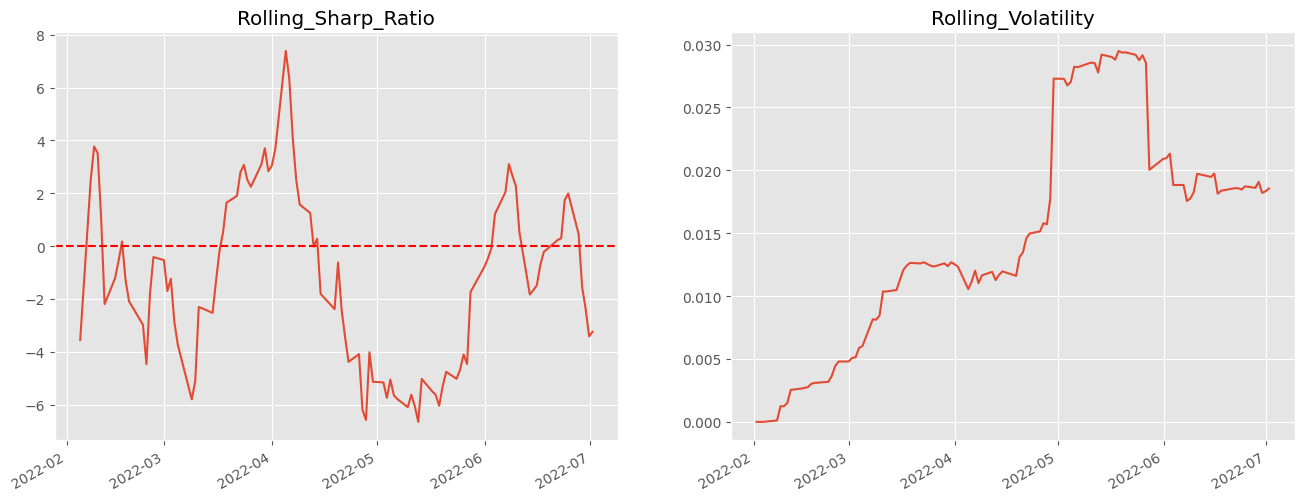

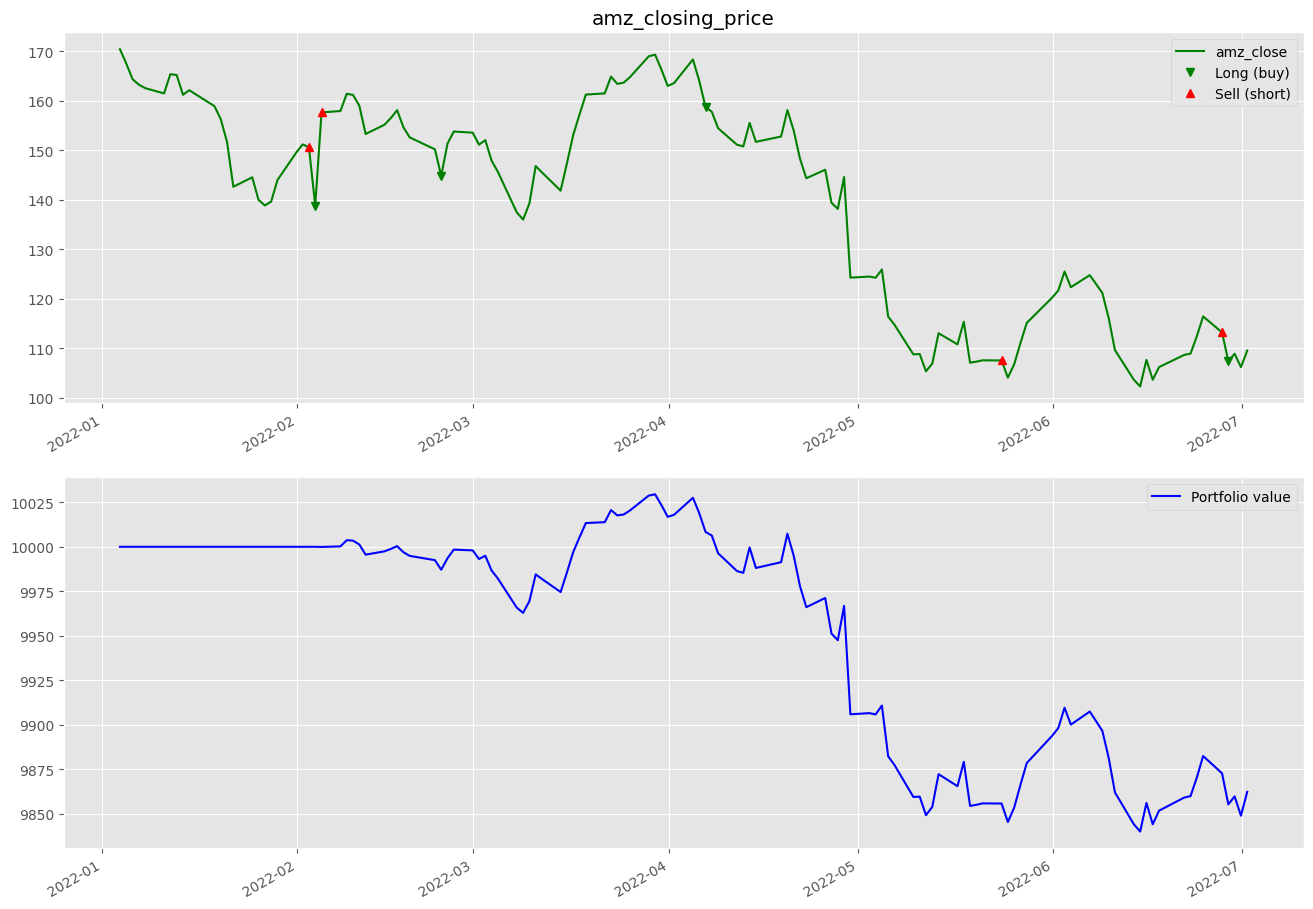

In [19]:
rolling_stats(result,20)

## RSI

In [20]:
def RSI(df, window, matype=1):
    df['gain'] = (df.close-df.open).apply(lambda x: x if x >0 else 0)
    df['loss'] = (df.close-df.open).apply(lambda x: -x if x <0 else 0)

    if matype==2:
        df['ema_gain'] = df["gain"].ewm(span=window,min_periods=window).mean()
        df['ema_loss'] = df["loss"].ewm(span=window,min_periods=window).mean()
    if matype==1:
        df['ema_gain'] = df["gain"].rolling(window).mean()
        df['ema_loss'] = df["loss"].rolling(window).mean()
    
    df['rs'] = df['ema_gain'] / df['ema_loss']
    df['rsi_14'] = 100 - (100 / (df['rs'] + 1))
    return df        

In [21]:
# df = result
# lag = 0
# rsi = RSI(df, 3, 1).rsi_14
# std_rsi = pd.Series(((rsi-rsi.mean())/rsi.std()).values, index=rsi.index+pd.Timedelta(lag))
# # Painting
# fig, ax = plt.subplots(2, 1, sharex=True, figsize=[16, 8])
# ax[0].plot(std_rsi, label="rsi normalized")
# ax[0].plot((df.close-df.close.mean())/df.close.std(), label="Price normalized")
# plt.legend()

# ax[1].plot(rsi, label="RSI")
# plt.legend()
# plt.show()

## Tearsheet

In [22]:
# returns_df = pd.DataFrame(result, columns=["returns"])
# pf.create_returns_tear_sheet(returns_df)

In [23]:
# returns = result['returns']
# pf.create_returns_tear_sheet(returns)

/home/yakub/.local/lib/python3.10/site-packages/pyfolio/plotting.py:666: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '-2.758%' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  perf_stats.loc[stat, column] = str(np.round(value * 100, 3)) + "%"


Start date,2022-01-03
End date,2022-07-01
Total months,5
,Backtest
Annual return,-2.758%
Cumulative returns,-1.378%
Annual volatility,1.671%
Sharpe ratio,-1.67
Calmar ratio,-1.46
Stability,0.68
Max drawdown,-1.89%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,1.89,2022-03-29,2022-06-14,NaT,NaN
1,0.41,2022-02-08,2022-03-08,2022-03-17,28
2,0.03,2022-03-22,2022-03-23,2022-03-28,5
3,0.00,2022-02-03,2022-02-04,2022-02-07,3
4,NaN,NaT,NaT,NaT,NaN


ConversionError: Failed to convert value(s) to axis units: (NaT, Timestamp('2022-07-01 00:00:00+0000', tz='UTC'))

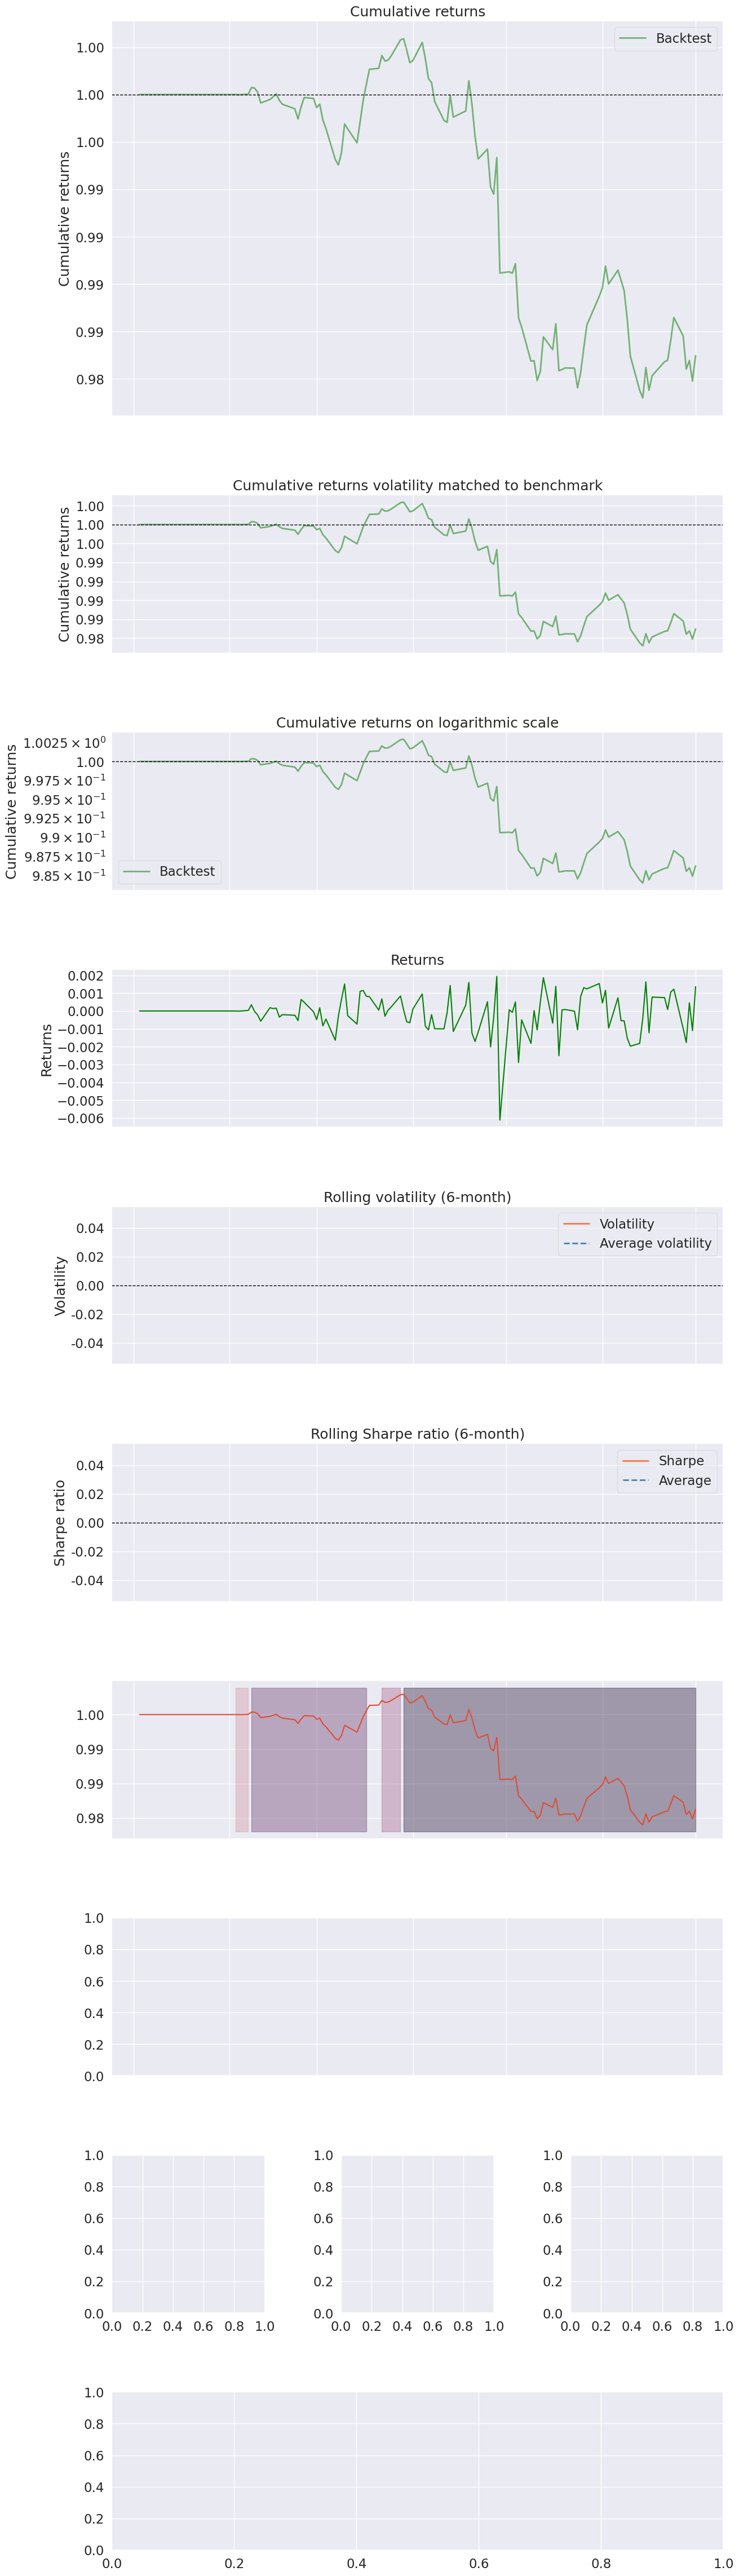

In [24]:
%load_ext autoreload
%autoreload 2

from pyfolio.utils import extract_rets_pos_txn_from_zipline
from pyfolio.tears import create_full_tear_sheet

returns, positions, transactions = extract_rets_pos_txn_from_zipline(result)

create_full_tear_sheet(returns, positions=positions, transactions=transactions)

In [ ]:
# from yahoofinancials import YahooFinancials
# import pandas as pd
# yahoo_financials = YahooFinancials('SOXL')
# data = yahoo_financials.get_historical_price_data(start_date="2010-03-01", end_date="2021-02-19", time_interval='daily')
# df=pd.DataFrame(data['SOXL']['prices']).drop(['date'], axis=1).rename(columns={'formatted_date':'date'})
# df = df[['date','open','high','low','adjclose','volume']]
# df = df.rename(columns={'adjclose':'close'})
# df['dividend'] = 0
# df['split'] = 0

In [4]:
%matplotlib inline
import quantstats as qs

# extend pandas functionality with metrics, etc.
qs.extend_pandas()

# fetch the daily returns for a stock
stock = qs.utils.download_returns('META')

# show sharpe ratio
qs.stats.sharpe(stock)

# or using extend_pandas() :)
stock.sharpe()

Failed to get ticker 'META' reason: unsupported operand type(s) for -: 'datetime.datetime' and 'str'


[*********************100%%**********************]  1 of 1 completed


1 Failed download:
['META']: Exception('%ticker%: No timezone found, symbol may be delisted')


ValueError: attempt to get argmax of an empty sequence

In [13]:
import pandas as pd
import yfinance as yf

aapl_df = yf.download('AAPL', 
                    start='2019-01-01', 
                    end='2021-01-01',
)

[*********************100%%**********************]  1 of 1 completed


1 Failed download:
['AAPL']: Exception('%ticker%: No price data found, symbol may be delisted (1d 2019-01-01 -> 2021-01-01)')


In [16]:
import logging
yf.enable_debug_mode()
import pandas as pd
import yfinance as yf

aapl_df = yf.download('AAPL', 
                    start='2019-01-01', 
                    end='2021-01-01',
)

DEBUG    Entering download()
DEBUG:yfinance:Entering download()
DEBUG     Disabling multithreading because DEBUG logging enabled
DEBUG:yfinance: Disabling multithreading because DEBUG logging enabled
DEBUG     Entering history()
DEBUG:yfinance: Entering history()
DEBUG      AAPL: Yahoo GET parameters: {'period1': '2019-01-01 00:00:00-05:00', 'period2': '2021-01-01 00:00:00-05:00', 'interval': '1d', 'includePrePost': False, 'events': 'div,splits,capitalGains'}
DEBUG:yfinance:  AAPL: Yahoo GET parameters: {'period1': '2019-01-01 00:00:00-05:00', 'period2': '2021-01-01 00:00:00-05:00', 'interval': '1d', 'includePrePost': False, 'events': 'div,splits,capitalGains'}
DEBUG      Entering get()
DEBUG:yfinance:  Entering get()
DEBUG       url=https://query2.finance.yahoo.com/v8/finance/chart/AAPL
DEBUG:yfinance:   url=https://query2.finance.yahoo.com/v8/finance/chart/AAPL
DEBUG       params=frozendict.frozendict({'period1': 1546318800, 'period2': 1609477200, 'interval': '1d', 'includePrePost': 

In [12]:
ticker = yf.Ticker('AMZN')
aapl_df = ticker.history(period="5y")

AMZN: No price data found, symbol may be delisted (period=5y)


In [18]:
from yahoofinancials import YahooFinancials

yahoo_financials = YahooFinancials('AAPL')
data = yahoo_financials.get_historical_price_data(start_date='2019-01-01', 
                                                  end_date='2019-12-31', 
                                                  time_interval='weekly')
aapl_df = pd.DataFrame(data['AAPL']['prices'])
aapl_df = aapl_df.drop('date', axis=1).set_index('formatted_date')
aapl_df.head()

TypeError: 'NoneType' object is not iterable